# The influence of weather on bike-sharing
## Sources of datasets:

[London weather data](https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023)

[Bike-Share Usage in London and Taipei Network](https://www.kaggle.com/datasets/ajohrn/bikeshare-usage-in-london-and-taipei-network/data)

### Things to do to run:
* Download these three datasets: London.csv, London_stations.csv (source 2) & london0_23_weather_data.csv (source 1)
* Place the files together with this code in a shared folder

To run the code (in VSC):
* Make sure you have Python installed (I'm using Python 3.11.9)
* To the upper right here, select this Python as kernel
* It migh be that you still need to select an environment to run the code, use .venv
* In the cell below: uncomment the pip-commands (only run this once, then comment them again)
* It should work now :)

## Installing and defining names and files

In [34]:
#pip install pandas

In [35]:
#pip install seaborn

In [36]:
#pip install scikit-learn

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
#We only look at the London-data (there is also data from Taipei network)
df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)
df_london.shape

C:\Users\jorri\AppData\Local\Temp\ipykernel_4376\2391621177.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)


(38215560, 9)

In [39]:
#import the names of the stations (a bit easier to identify stations later)
df_london_geo = pd.read_csv('london_stations.csv')


In [40]:
#import weather data of London (this goes from 2000-2023, so we can discard a lot later)
df_london_weather = pd.read_csv('london0_23_weather_data.csv')

#Deleting NaN's
df_london_weather = df_london_weather.drop('tsun', axis=1)
df_london_weather = df_london_weather.drop('wpgt', axis=1)
df_london_weather['snow'] = df_london_weather['snow'].fillna(0)
df_london_weather['prcp'] = df_london_weather['prcp'].fillna(0)
    # Interpolate the other missing values linearly
df_london_weather = df_london_weather.interpolate(method='linear')
df_london_weather.loc[0, 'wdir'] = 255

#Since there is no explicit date column, I create one for our ease (starting from 01-01-2000):
df_london_weather['date'] = pd.date_range(start='2000-01-01', periods=len(df_london_weather), freq='D') 
# Extract useful time-related features
df_london_weather['day'] = df_london_weather['date'].dt.day
df_london_weather['month'] = df_london_weather['date'].dt.month
df_london_weather['week'] = df_london_weather['date'].dt.isocalendar().week
df_london_weather['dayofweek'] = df_london_weather['date'].dt.dayofweek
df_london_weather['year'] = df_london_weather['date'].dt.year
df_london_weather['satsun'] = df_london_weather['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})

# Display the first few rows
df_london_weather.head(8)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,date,day,month,week,dayofweek,year,satsun
0,7.3,3.1,9.000000,1.8,0.0,255.0,2.3,1024.5,2000-01-01,1,1,52,5,2000,True
1,9.5,8.0,11.000000,0.0,0.0,225.0,11.6,1025.2,2000-01-02,2,1,52,6,2000,True
2,9.4,5.6,11.200000,2.0,0.0,233.0,16.8,1018.5,2000-01-03,3,1,1,0,2000,False
3,5.7,2.8,9.500000,3.8,0.0,229.0,17.0,1014.8,2000-01-04,4,1,1,1,2000,False
4,7.1,1.9,10.066667,0.0,0.0,225.0,17.2,1015.6,2000-01-05,5,1,1,2,2000,False
5,8.8,3.8,10.633333,0.0,0.0,221.0,17.4,1016.4,2000-01-06,6,1,1,3,2000,False
6,8.8,5.7,11.200000,0.0,0.0,217.0,17.6,1017.2,2000-01-07,7,1,1,4,2000,False
7,8.3,5.5,10.300000,0.0,0.0,241.0,16.3,1016.4,2000-01-08,8,1,1,5,2000,True


In [41]:
#The data includes rare rental events that are started but not ended. For this analysis these are best removed.
df_london = df_london.loc[~df_london.isnull().any(axis=1)]
df_london = df_london.astype({'bike_id' : 'int32', 'end_station_id' : 'int32', 'start_station_id' : 'int32'})
df_london.shape

(38147278, 9)

In [42]:
#Augment datetime data to make it easier for binning and applying conditions with respect to time.
df_london.loc[:, 'year'] = df_london['start_rental_date_time'].dt.year
df_london.loc[:, 'month'] = df_london['start_rental_date_time'].dt.month
df_london.loc[:, 'week'] = df_london['start_rental_date_time'].dt.isocalendar().week
df_london.loc[:, 'day'] = df_london['start_rental_date_time'].dt.day
df_london.loc[:, 'hour'] = df_london['start_rental_date_time'].dt.hour
df_london.loc[:, 'dayofweek'] = df_london['start_rental_date_time'].dt.dayofweek
df_london.loc[:, 'satsun'] = df_london['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_london.shape
df_london.head(3)

,rental_id,duration,bike_id,end_rental_date_time,end_station_id,end_station_name,start_rental_date_time,start_station_id,start_station_name,year,month,week,day,hour,dayofweek,satsun
0,61343322,60.0,12871,2016-12-28 00:01:00,660,"West Kensington Station, West Kensington",2016-12-28,633,"Vereker Road North, West Kensington",2016,12,52,28,0,2,False
1,61343321,300.0,2837,2016-12-28 00:05:00,763,"Mile End Park Leisure Centre, Mile End",2016-12-28,531,"Twig Folly Bridge, Mile End",2016,12,52,28,0,2,False
2,61343323,360.0,1269,2016-12-28 00:06:00,99,"Old Quebec Street, Marylebone",2016-12-28,116,"Little Argyll Street, West End",2016,12,52,28,0,2,False


In [43]:
#A handful of stations are very rarely part of any rental events. 
#In some cases these are temporary stations or stations that become decommissioned. 
#In some analysis these low count stations are best removed.

below_or_above_stations = df_london['start_station_name'].value_counts() < 500
low_stations = below_or_above_stations.loc[below_or_above_stations].index
df_london = df_london.loc[~df_london['start_station_name'].isin(low_stations)]
df_london = df_london.loc[~df_london['end_station_name'].isin(low_stations)]
df_london.shape

(38144414, 16)

[Text(0, 0.5, 'number of rentals')]

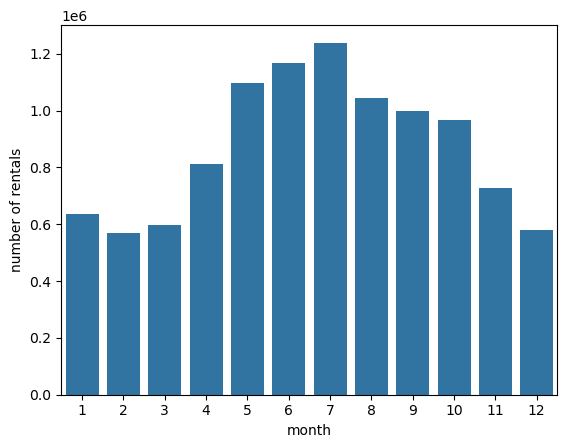

In [44]:
#small test: the number of rental events in the months of a particular year, say 2018
per_month_2018_group = df_london.loc[df_london['year'] == 2018].groupby('month')
month_counts = per_month_2018_group.count()

ax=sns.barplot(x=month_counts.index, y=month_counts.iloc[:,0])
ax.set(ylabel='number of rentals')

<Axes: xlabel='hour'>

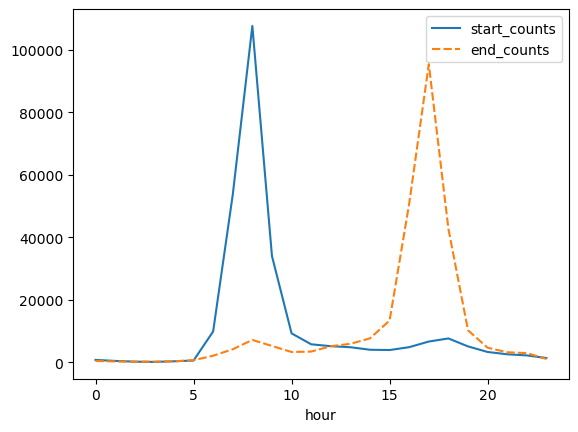

In [45]:
weekday_14_start = df_london.loc[(df_london['start_station_id'] == 14) & (df_london['satsun'] == False)] # only weekdays for station 14
weekday_14_end = df_london.loc[(df_london['end_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_start = weekday_14_start.groupby('hour').count()
weekday_14_end = weekday_14_end.groupby('hour').count()
weekday_14_data = pd.DataFrame({'start_counts' : weekday_14_start.iloc[:,0],
                                'end_counts' : weekday_14_end.iloc[:,0]})

sns.lineplot(data=weekday_14_data)

## The analysis

Although we might strongly suspect a correlation between weather and bike usage, I will first plot both their values to see if we see a (rough) correlation. This has still nothing to do with the data-driven part

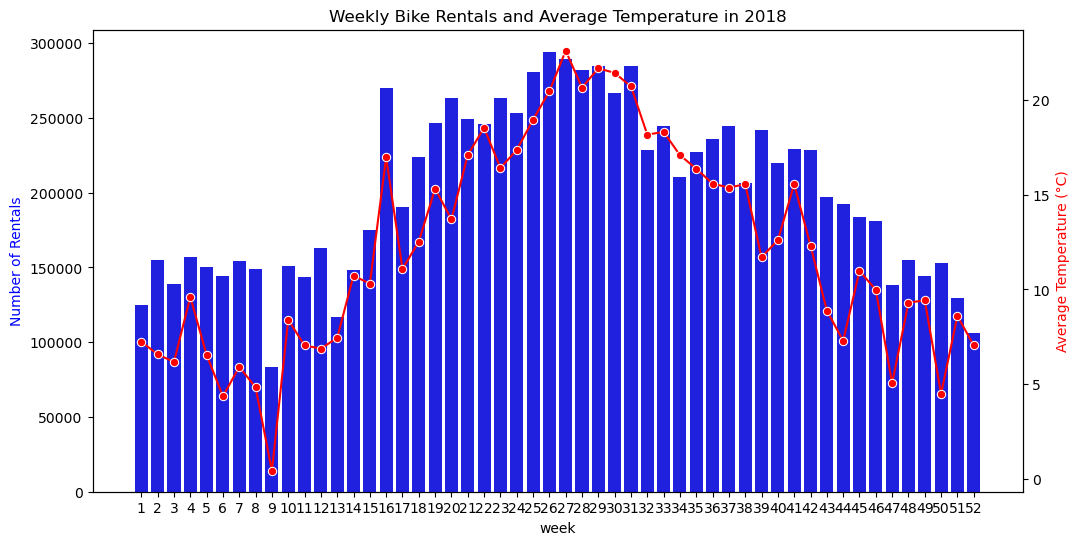

In [46]:
#Let's do it for each week in 2018
#Total number of bike rentals in the week:
per_week_2018_group = df_london.loc[df_london['year'] == 2018].groupby('week')
week_counts = per_week_2018_group.count()

# Compute the average temperature for each whole week of 2018
df_2018 = df_london_weather[df_london_weather['year'] == 2018]
avg_weekly_temp_2018 = df_2018.groupby('week')['tavg'].mean()

#Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=week_counts.index, y=week_counts.iloc[:,0], color='b', ax=ax1)
ax1.set_ylabel('Number of Rentals', color='b')

ax2 = ax1.twinx()
sns.lineplot(x=avg_weekly_temp_2018.index-1, y=avg_weekly_temp_2018, color='r', marker='o', ax=ax2)
ax2.set_ylabel('Average Temperature (°C)', color='r')

plt.title('Weekly Bike Rentals and Average Temperature in 2018')
plt.show()

I think we can conclude that there might definitely be a correlation between the average temperature and the number of bike rentals (clear for example in week 9 and 16)

### Just some ideas: 
We might see all weather-elements of a day as 'variables' and the number of bike-rides of a day as 'output'. We could do a PCA on these?

I don't know if we saw anything of this in class, but you might see all stations as nodes and the bikerides inbetween them as links. This way you can create a graph and show which stations are the most important (I mean from where to where is most driven), there is a kind of example of this in here: https://towardsdatascience.com/london-bike-ride-forecasting-with-graph-convolutional-networks-aee044e48131/

Creating a Neural Network to forecast the bike usage based on the data of the weather (of the same day, or maybe of the day before idk?)

Other ideas are welcome :)

### PCA on Weather data
I tried to get to 3 PCA's instead of 8. This gets us to 69,5%

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


start_data = df_london_weather.loc[:, 'tavg':'pres']
weather_features = start_data.columns.to_list()
n_features = len(weather_features)
start_data.head(8)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
0,7.3,3.1,9.000000,1.8,0.0,255.0,2.3,1024.5
1,9.5,8.0,11.000000,0.0,0.0,225.0,11.6,1025.2
2,9.4,5.6,11.200000,2.0,0.0,233.0,16.8,1018.5
3,5.7,2.8,9.500000,3.8,0.0,229.0,17.0,1014.8
4,7.1,1.9,10.066667,0.0,0.0,225.0,17.2,1015.6
5,8.8,3.8,10.633333,0.0,0.0,221.0,17.4,1016.4
6,8.8,5.7,11.200000,0.0,0.0,217.0,17.6,1017.2
7,8.3,5.5,10.300000,0.0,0.0,241.0,16.3,1016.4


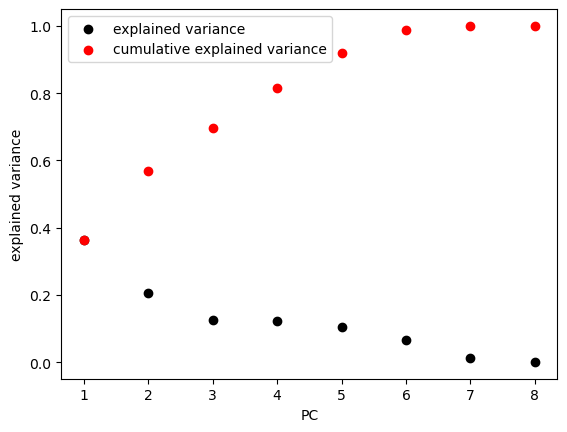

In [48]:
scaler = StandardScaler()
start_data_0 = scaler.fit_transform(start_data)

pca = PCA(n_components=n_features) #all featuresbecause we want to look at eigvals distribution
pca.fit(start_data_0)

A = pca.components_.T
Z = start_data_0 @ A
ex_var = pca.explained_variance_ratio_
cum_ex_var = np.cumsum(ex_var)

plt.scatter(1+np.arange(n_features), ex_var, c='k', label='explained variance')
plt.scatter(1+np.arange(n_features), cum_ex_var, c='r', label='cumulative explained variance')
plt.xlabel('PC')
plt.ylabel('explained variance')
plt.legend()
plt.show()

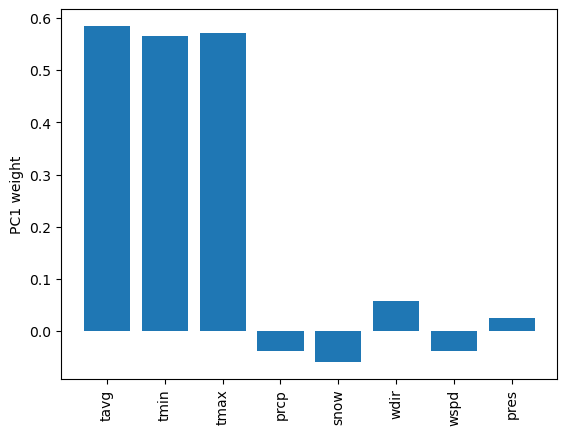

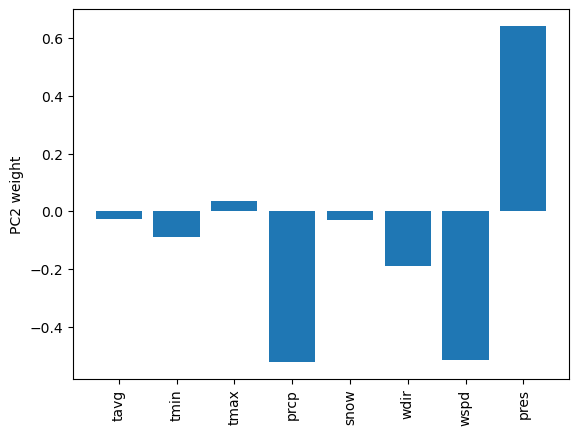

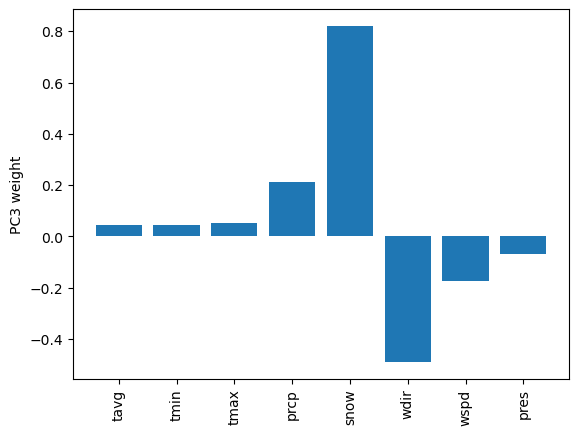

In [49]:
plt.bar(np.arange(n_features), A[:, 0])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC1 weight')
plt.show()

plt.bar(np.arange(n_features), A[:, 1])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC2 weight')
plt.show()

plt.bar(np.arange(n_features), A[:, 2])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC3 weight')
plt.show()

The clustering doesn't tell us much, but I did it anyway just to test

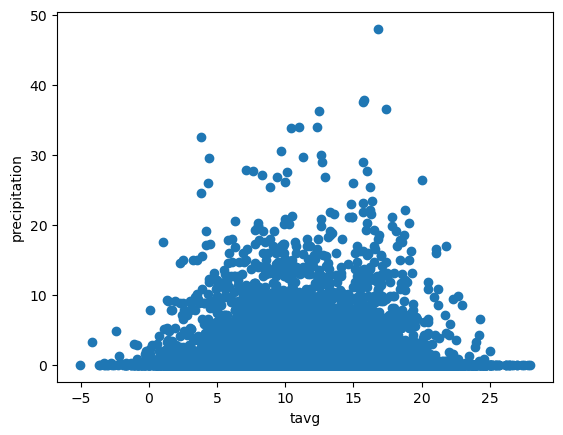

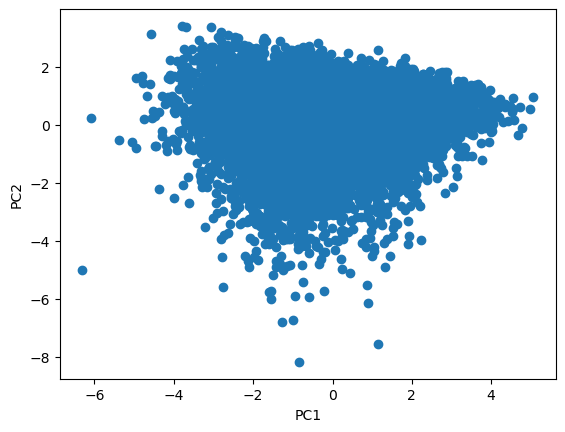

In [50]:
plt.scatter(start_data.loc[:, 'tavg'], start_data.loc[:, 'prcp']) #bad clustering
plt.xlabel('tavg')
plt.ylabel('precipitation')
plt.show()

plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show() #better clustering

### Data Integration:
Here we merge both database to find some correlation between them afterwards.

In [51]:
# Convert 'start_rental_date_time' to date (if not already done)
df_london['date'] = df_london['start_rental_date_time'].dt.date  

# Aggregate total rentals per day
daily_rentals = df_london.groupby('date').size().reset_index(name='rental_count')  
daily_rentals.head(3)  

,date,rental_count
0,2016-12-28,12387
1,2016-12-29,14012
2,2016-12-30,11537


In [52]:
# Ensure weather 'date' column is in date format (if not already done)
df_london_weather['date'] = pd.to_datetime(df_london_weather['date']).dt.date  

# Keep only relevant weather columns (optional: you can include more features later)
weather_subset = df_london_weather[['date', 'tavg', 'prcp', 'wspd', 'snow']]  
weather_subset.head(3)  

,date,tavg,prcp,wspd,snow
0,2000-01-01,7.3,1.8,2.3,0.0
1,2000-01-02,9.5,0.0,11.6,0.0
2,2000-01-03,9.4,2.0,16.8,0.0


In [53]:
# Merge on 'date'
merged_data = pd.merge(daily_rentals, weather_subset, on='date', how='inner')  

# Check for missing values (should be none, since we cleaned earlier)
print(merged_data.isnull().sum())  

merged_data.head(3)  

date            0
rental_count    0
tavg            0
prcp            0
wspd            0
snow            0
dtype: int64


,date,rental_count,tavg,prcp,wspd,snow
0,2016-12-28,12387,2.1,0.0,7.5,0.0
1,2016-12-29,14012,3.8,0.3,5.8,0.0
2,2016-12-30,11537,3.2,0.5,8.8,0.0


### Correlation
Between the number of bikes rented and the different weather variables

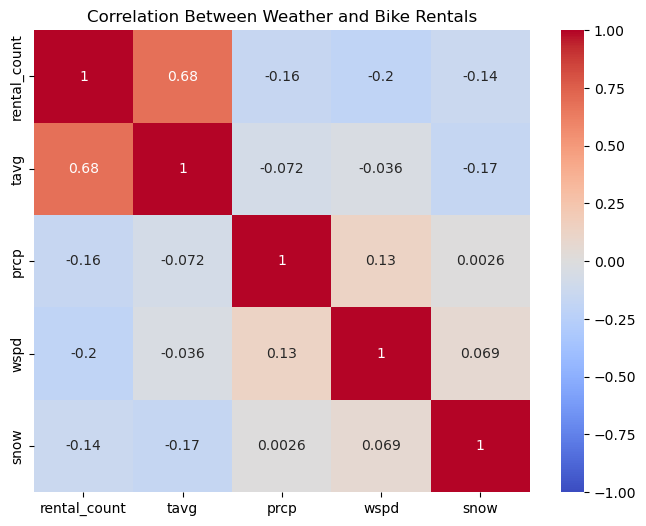


Correlation Insights:
1. tavg (temperature): STRONGEST driver (+0.68)
2. wspd (wind speed): Mild deterrent (-0.20)
3. prcp (precipitation): Mild deterrent (-0.16) 
4. snow: Minimal impact (-0.14) but rare in London



In [54]:
# Compute correlation matrix
corr_matrix = merged_data[['rental_count', 'tavg', 'prcp', 'wspd', 'snow']].corr()  

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)  
plt.title("Correlation Between Weather and Bike Rentals")  
plt.show() 

print("""
Correlation Insights:
1. tavg (temperature): STRONGEST driver (+0.68)
2. wspd (wind speed): Mild deterrent (-0.20)
3. prcp (precipitation): Mild deterrent (-0.16) 
4. snow: Minimal impact (-0.14) but rare in London
""")

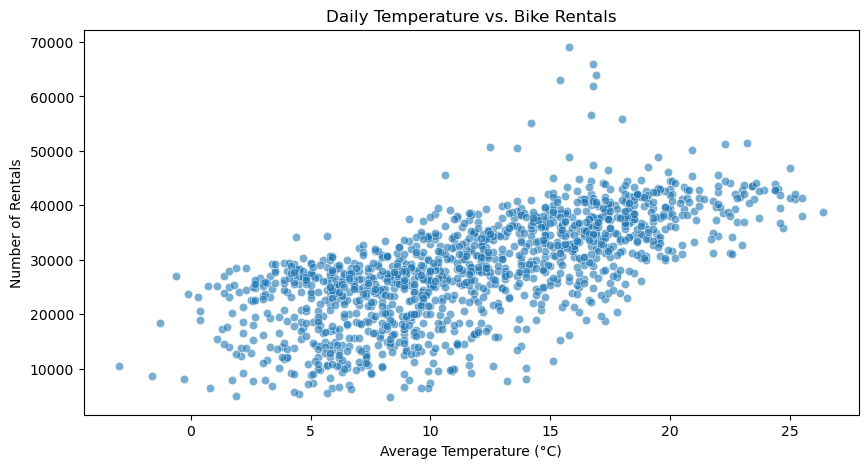


Temperature Impact:
- Strong positive correlation (r=0.68): Rentals increase with temperature.
- Optimal range: 10-25°C (peak usage).
- Sharp decline below 5°C.



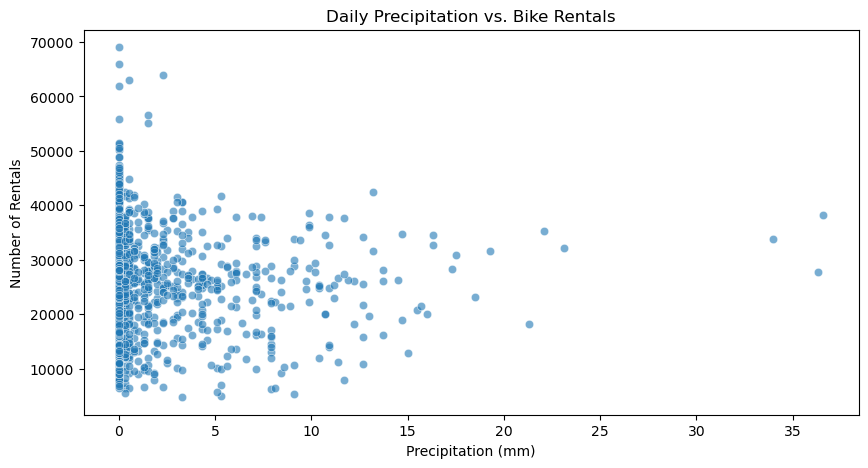


Precipitation Impact:
- Mild negative correlation (r=-0.16): Rain reduces usage.
- Heavy rain (>20mm) has clearer impact.
- Most days have 0-5mm rain (minimal effect).



In [55]:
# Temperature vs. Rentals
plt.figure(figsize=(10, 5))
sns.scatterplot(x='tavg', y='rental_count', data=merged_data, alpha=0.6)  
plt.title("Daily Temperature vs. Bike Rentals")  
plt.xlabel("Average Temperature (°C)")  
plt.ylabel("Number of Rentals")  
plt.show()  

print("""
Temperature Impact:
- Strong positive correlation (r=0.68): Rentals increase with temperature.
- Optimal range: 10-25°C (peak usage).
- Sharp decline below 5°C.
""")

# Precipitation vs. Rentals
plt.figure(figsize=(10, 5))
sns.scatterplot(x='prcp', y='rental_count', data=merged_data, alpha=0.6)  
plt.title("Daily Precipitation vs. Bike Rentals")  
plt.xlabel("Precipitation (mm)")  
plt.ylabel("Number of Rentals")  
plt.show()  

print("""
Precipitation Impact:
- Mild negative correlation (r=-0.16): Rain reduces usage.
- Heavy rain (>20mm) has clearer impact.
- Most days have 0-5mm rain (minimal effect).
""")

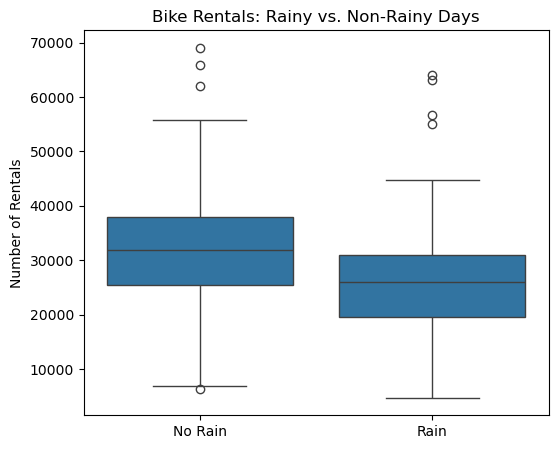

In [56]:
# Create a binary column: 1 if rain > 0, else 0
merged_data['has_rain'] = (merged_data['prcp'] > 0).astype(int)  

# Compare rentals on rainy vs. non-rainy days
plt.figure(figsize=(6, 5))
sns.boxplot(x='has_rain', y='rental_count', data=merged_data)  
plt.title("Bike Rentals: Rainy vs. Non-Rainy Days")  
plt.xticks([0, 1], ["No Rain", "Rain"])  
plt.xlabel("")  
plt.ylabel("Number of Rentals")  
plt.show()  

### Feature engineering:
We'll transform raw data to better predict rentals:

Temperature:

    Linear term (tavg) → Measures constant rate of change

    Quadratic term (tavg_squared) → Captures "too hot" or "too cold" effects

Precipitation:

    Binary heavy_rain flag for >5mm days (more impactful than drizzle)

Lagged terms: Accounts for temporal dependencies

In [76]:
# Convert 'date' column to datetime if it's not already
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Temperature Effects (Nonlinear)
merged_data['tavg_squared'] = merged_data['tavg'] ** 2  # Polynomial term

# 2. Precipitation Impact (Binary Threshold)
merged_data['heavy_rain'] = (merged_data['prcp'] > 5).astype(int)  # Optimization-based threshold

# 3. Temporal Features
merged_data['is_weekend'] = merged_data['date'].dt.dayofweek.isin([5, 6]).astype(int)
merged_data['month'] = merged_data['date'].dt.month  # Seasonality
# 4. Lagged Weather (Time Dependency)
merged_data['tavg_lag1'] = merged_data['tavg'].shift(1)  # Previous day's temp
merged_data['prcp_lag1'] = merged_data['prcp'].shift(1)  # Previous day's rain

# Drop rows with missing values
merged_data = merged_data.dropna()


Train-test split

In [78]:
# Split into train (2017-2018) and test (2019-2020)
train = merged_data[merged_data['date'].dt.year.isin([2017, 2018])]
test = merged_data[merged_data['date'].dt.year >= 2019]

# Define features and target
features = [
    'tavg', 'tavg_squared',  # Linear + Nonlinear temp
    'heavy_rain', 'prcp_lag1',  # Precipitation effects
    'wspd',  # Wind speed
    'is_weekend', 'month'  # Temporal controls
]
X_train, y_train = train[features], train['rental_count']
X_test, y_test = test[features], test['rental_count']

Linear regression and evaluation

In [79]:
# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
test['predicted'] = model.predict(X_test)
mae = mean_absolute_error(y_test, test['predicted'])
r2 = r2_score(y_test, test['predicted'])

print(f"MAE: {mae:.0f} rentals")
print(f"R²: {r2:.2f} (1.0 is perfect)")

MAE: 5614 rentals
R²: 0.40 (1.0 is perfect)


C:\Users\jorri\AppData\Local\Temp\ipykernel_4376\273668455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = model.predict(X_test)



Feature Impacts:
        feature       impact
0          tavg  1088.467270
1  tavg_squared     3.632186
3     prcp_lag1   -70.532638
6         month  -149.215754
4          wspd  -219.365501
2    heavy_rain -3556.520904
5    is_weekend -7079.859230


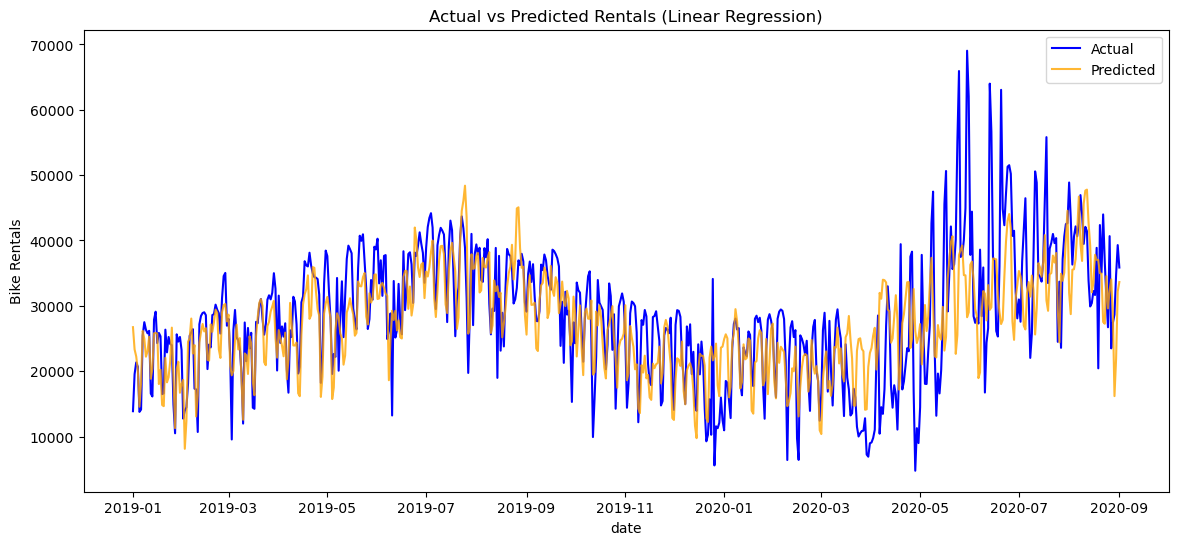

In [80]:
# Get coefficients
coefs = pd.DataFrame({
    'feature': features,
    'impact': model.coef_
}).sort_values('impact', ascending=False)

print("\nFeature Impacts:")
print(coefs)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
sns.lineplot(data=test, x='date', y='rental_count', label='Actual', color='blue')
sns.lineplot(data=test, x='date', y='predicted', label='Predicted', color='orange', alpha=0.8)
plt.title("Actual vs Predicted Rentals (Linear Regression)")
plt.ylabel("Bike Rentals")
plt.legend()
plt.show()

### Problem Diagnosis:
Poor Performance Indicators:

- MAE (5614): Predictions are off by ~5,614 rentals/day (very high for London's system).

- R² (0.40): Only 40% of rental variance is explained by your model.

Suspicious Coefficients:

- is_weekend: -7079 → Implies weekends have fewer rentals than weekdays (contradicts real-world logic!)

- month: -149 → Rentals decrease every month (nonsensical trend)

- tavg: +1088 → Each 1°C increase → 1,088 more rentals (unrealistically large)
